<a href="https://colab.research.google.com/github/kriti524/GNSS-vehicle-tracking-and-tolling-system/blob/main/Gnss_Based_vehicle_tracking_and_Tolling_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-6-02a520e6bb40>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_data['cluster'] = np.concatenate([np.full(len(sampled_data[sampled_data['device'] == device]), trajectory_labels[i])


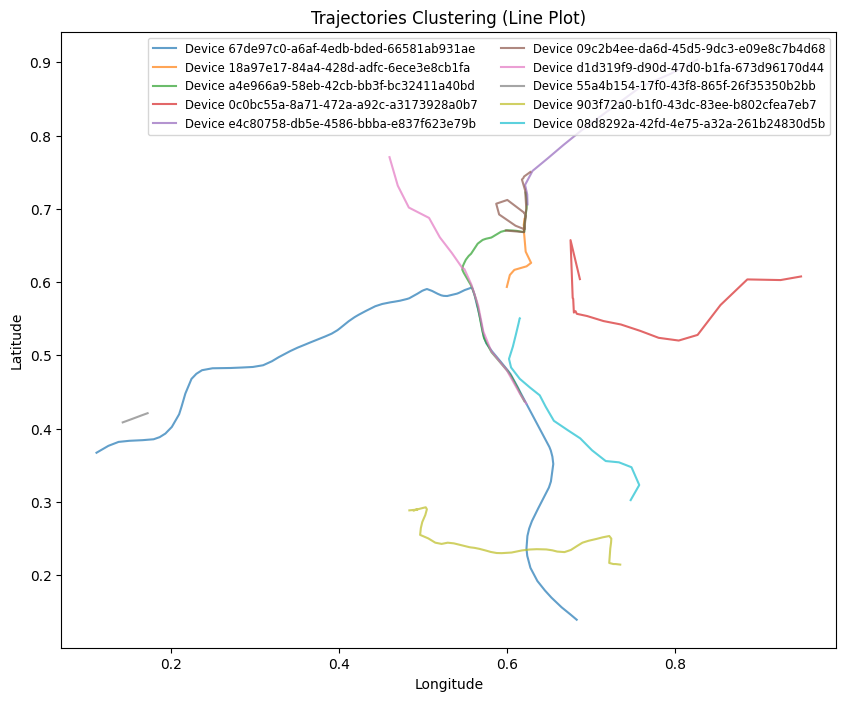

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from math import radians, sin, cos, asin, sqrt
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

def d(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * sin(sqrt(a))
    m = 6367 * c * 1000  # Convert to meters

    return m

def haversine_distance(trajectory1, trajectory2):
    distance = 0
    for i in range(len(trajectory1)):
        for j in range(len(trajectory2)):
            distance += d(trajectory1[i, 0], trajectory1[i, 1], trajectory2[j, 0], trajectory2[j, 1])
    return distance

def cluster_trajectories(trajectories, epsilon, min_samples):
    # Compute the distance matrix for a small subset of trajectories
    num_trajectories = len(trajectories)
    distance_matrix = np.zeros((num_trajectories, num_trajectories))

    for i in range(num_trajectories):
        for j in range(i + 1, num_trajectories):
            distance = haversine_distance(trajectories[i], trajectories[j])
            distance_matrix[i, j] = distance
            distance_matrix[j, i] = distance

    # Create a DBSCAN model with the specified parameters
    model = DBSCAN(eps=epsilon, min_samples=min_samples, metric='precomputed')
    # Fit the model to the distance matrix
    model.fit(distance_matrix)
    # Get the cluster labels
    labels = model.labels_
    return labels

# Load the dataset
data = pd.read_csv("points_anonymized.csv", delimiter=";")
data["timestamp"] = pd.to_datetime(data["timestamp"])
data['timestamp'] = data['timestamp'].astype(int) / 10**9
data = data.drop(labels=["speed", "subid", "heading"], axis=1)

# Normalize the longitude and latitude columns
scaler = MinMaxScaler()
data[['lon', 'lat']] = scaler.fit_transform(data[['lon', 'lat']])
data['lon'] = pd.to_numeric(data['lon'], errors='coerce')
data['lat'] = pd.to_numeric(data['lat'], errors='coerce')

# Sample a subset of the data for clustering
sampled_devices = data["device"].unique()[:10]  # Adjust number of devices as needed
sampled_data = data[data["device"].isin(sampled_devices)]

# Convert the sampled data to a suitable format for clustering
trajectories = []
labels_dict = {}
for i, volunteer_id in enumerate(sampled_data["device"].unique()):
    volunteer_data = sampled_data[sampled_data["device"] == volunteer_id]
    trajectory = volunteer_data[["lon", "lat"]].values
    trajectories.append(trajectory)
    labels_dict[volunteer_id] = i  # Map device ID to its index in the trajectories list

# Perform clustering on the sampled data
epsilon = 0.1  # adjust this value based on the desired cluster density
min_samples = 5  # adjust this value based on the desired minimum cluster size
trajectory_labels = cluster_trajectories(trajectories, epsilon, min_samples)

# Map trajectory labels back to original data points
sampled_data['cluster'] = np.concatenate([np.full(len(sampled_data[sampled_data['device'] == device]), trajectory_labels[i])
                                           for i, device in enumerate(sampled_data['device'].unique())])

# Visualize the clusters with line plots
fig, ax = plt.subplots(figsize=(10, 8))

# Iterate through each device and plot its trajectory
for device in sampled_data["device"].unique():
    device_data = sampled_data[sampled_data["device"] == device]
    ax.plot(device_data["lon"], device_data["lat"], label=f'Device {device}', alpha=0.7)  # Line plot for each trajectory

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Trajectories Clustering (Line Plot)')
plt.legend(loc='best', fontsize='small', ncol=2)  # Add legend to distinguish devices
plt.show()


In [ ]:
import folium
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from math import radians, sin, cos, sqrt

# Haversine distance function
def d(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * sin(sqrt(a))
    return 6367 * c * 1000  # Distance in meters

def haversine_distance(trajectory1, trajectory2):
    distance = 0
    for i in range(len(trajectory1)):
        for j in range(len(trajectory2)):
            distance += d(trajectory1[i, 0], trajectory1[i, 1], trajectory2[j, 0], trajectory2[j, 1])
    return distance

def cluster_trajectories(trajectories, epsilon, min_samples):
    num_trajectories = len(trajectories)
    distance_matrix = np.zeros((num_trajectories, num_trajectories))

    for i in range(num_trajectories):
        for j in range(i + 1, num_trajectories):
            distance = haversine_distance(trajectories[i], trajectories[j])
            distance_matrix[i, j] = distance
            distance_matrix[j, i] = distance

    model = DBSCAN(eps=epsilon, min_samples=min_samples, metric='precomputed')
    model.fit(distance_matrix)
    labels = model.labels_
    return labels

# Load the dataset
data = pd.read_csv("points_anonymized.csv", delimiter=";")
data["timestamp"] = pd.to_datetime(data["timestamp"])
data['timestamp'] = data['timestamp'].astype(int) / 10**9
data = data.drop(labels=["speed", "subid", "heading"], axis=1)

# Skip normalization for geographic coordinates
# data[['lon', 'lat']] = scaler.fit_transform(data[['lon', 'lat']])
data['lon'] = pd.to_numeric(data['lon'], errors='coerce')
data['lat'] = pd.to_numeric(data['lat'], errors='coerce')

# Sample a subset of the data for clustering
sampled_devices = data["device"].unique()[:50]  # Adjust number of devices as needed
sampled_data = data[data["device"].isin(sampled_devices)]

# Convert the sampled data to a suitable format for clustering
trajectories = []
for device in sampled_data["device"].unique():
    trajectory = sampled_data[sampled_data["device"] == device][["lon", "lat"]].values
    trajectories.append(trajectory)

# Perform clustering on the sampled data
epsilon = 0.1  # Adjust this value based on the desired cluster density
min_samples = 5  # Adjust this value based on the desired minimum cluster size
trajectory_labels = cluster_trajectories(trajectories, epsilon, min_samples)

# Map trajectory labels back to original data points
sampled_data['cluster'] = np.concatenate([np.full(len(sampled_data[sampled_data['device'] == device]), trajectory_labels[i])
                                          for i, device in enumerate(sampled_data['device'].unique())])

# Create a Folium map centered around the average lat/lon
avg_lat = sampled_data['lat'].mean()
avg_lon = sampled_data['lon'].mean()
m = folium.Map(location=[avg_lat, avg_lon], zoom_start=12)

# Add each trajectory as a PolyLine
for device in sampled_data['device'].unique():
    device_data = sampled_data[sampled_data['device'] == device]
    points = device_data[['lat', 'lon']].values.tolist()  # Get lat/lon pairs
    folium.PolyLine(points, color='red', opacity=0.6).add_to(m)  # Add trajectory line to map

# Display the map
m


<ipython-input-7-1cb00ace17f6>:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_data['cluster'] = np.concatenate([np.full(len(sampled_data[sampled_data['device'] == device]), trajectory_labels[i])


In [ ]:
import folium
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from math import radians, sin, cos, sqrt
from IPython.display import display, HTML

# Haversine distance function
def d(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * sin(sqrt(a))
    return 6367 * c * 1000  # Distance in meters

def haversine_distance(trajectory1, trajectory2):
    distance = 0
    for i in range(len(trajectory1)):
        for j in range(len(trajectory2)):
            distance += d(trajectory1[i, 0], trajectory1[i, 1], trajectory2[j, 0], trajectory2[j, 1])
    return distance

def cluster_trajectories(trajectories, epsilon, min_samples):
    num_trajectories = len(trajectories)
    distance_matrix = np.zeros((num_trajectories, num_trajectories))

    for i in range(num_trajectories):
        for j in range(i + 1, num_trajectories):
            distance = haversine_distance(trajectories[i], trajectories[j])
            distance_matrix[i, j] = distance
            distance_matrix[j, i] = distance

    model = DBSCAN(eps=epsilon, min_samples=min_samples, metric='precomputed')
    model.fit(distance_matrix)
    labels = model.labels_
    return labels

# Load the dataset
data = pd.read_csv("points_anonymized.csv", delimiter=";")
data["timestamp"] = pd.to_datetime(data["timestamp"])
data['timestamp'] = data['timestamp'].astype(int) / 10**9
data = data.drop(labels=["speed", "subid", "heading"], axis=1)

# Skip normalization for geographic coordinates
data['lon'] = pd.to_numeric(data['lon'], errors='coerce')
data['lat'] = pd.to_numeric(data['lat'], errors='coerce')

# Sample a subset of the data for clustering
sampled_devices = data["device"].unique()[:10]  # Adjust number of devices as needed
sampled_data = data[data["device"].isin(sampled_devices)]

# Convert the sampled data to a suitable format for clustering
trajectories = []
for device in sampled_data["device"].unique():
    trajectory = sampled_data[sampled_data["device"] == device][["lon", "lat"]].values
    trajectories.append(trajectory)

# Perform clustering on the sampled data
epsilon = 0.1  # Adjust this value based on the desired cluster density
min_samples = 5  # Adjust this value based on the desired minimum cluster size
trajectory_labels = cluster_trajectories(trajectories, epsilon, min_samples)

# Map trajectory labels back to original data points
sampled_data['cluster'] = np.concatenate([np.full(len(sampled_data[sampled_data['device'] == device]), trajectory_labels[i])
                                          for i, device in enumerate(sampled_data['device'].unique())])

# Create separate maps for each device
maps_html = ""
device_count = 10

for device in sampled_data['device'].unique():
    device_data = sampled_data[sampled_data['device'] == device]
    avg_lat = device_data['lat'].mean()
    avg_lon = device_data['lon'].mean()

    # Create a Folium map centered around the average lat/lon
    m = folium.Map(location=[avg_lat, avg_lon], zoom_start=15, control_scale=True)

    # Add each trajectory as a PolyLine
    points = device_data[['lat', 'lon']].values.tolist()  # Get lat/lon pairs
    folium.PolyLine(points, color='blue',dash_array='5', opacity=0.6).add_to(m)  # Add trajectory line to map

    # Save the map as HTML and add it to the HTML container
    map_html = m._repr_html_()  # Get the map's HTML representation
    maps_html += f"<div style='width: 300px; height: 300px; display: inline-block; margin: 10px;'>{map_html}</div>"

    device_count += 1
    if device_count % 3 == 0:
        maps_html += "<br/>"  # Add a line break after every 3 maps

# Display all maps in the notebook
display(HTML(f"<div style='display: flex; flex-wrap: wrap;'>{maps_html}</div>"))


<ipython-input-8-a2aae535fa94>:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_data['cluster'] = np.concatenate([np.full(len(sampled_data[sampled_data['device'] == device]), trajectory_labels[i])


In [ ]:
import pandas as pd
import folium
from IPython.display import display, HTML

# Load the dataset
data = pd.read_csv("/content/germany.csv", delimiter=",")

# Remove unnecessary columns
data = data[['longitude', 'latitude']]

# Sample 1000 rows for visualization
data_sample = data.sample(n=1000, random_state=42)

# Initialize a Folium map
avg_lat = data_sample['latitude'].mean()
avg_lon = data_sample['longitude'].mean()
m = folium.Map(location=[avg_lat, avg_lon], zoom_start=15, control_scale=True)

# Group by segments (if your data has a way to group segments)
# For this example, we assume each row is a part of a continuous path and simulate paths with multiple points.

# Create dummy paths (assuming linear segments between points for simplicity)
# You need to adjust this based on how your actual data is structured
path_coords = []
for i in range(len(data_sample) - 1):
    start = data_sample.iloc[i]
    end = data_sample.iloc[i + 1]
    path_coords.append([(start['latitude'], start['longitude']),
                        (end['latitude'], end['longitude'])])

# Add each path as a PolyLine
for path in path_coords:
    folium.PolyLine(path, color='blue', weight=1, opacity=0.6).add_to(m)

# Display the map
map_html = m._repr_html_()
display(HTML(f"<div style='width: 100%; height: 600px;'>{map_html}</div>"))


In [ ]:
import pandas as pd
import numpy as np
from shapely.geometry import Point, LineString
from shapely.ops import nearest_points

import pandas as pd
from shapely.geometry import LineString, Point

# Load road network data
road_data = pd.read_csv("road_network.csv", delimiter=",")

# Filter road network data
subset_road_data = road_data[
    (road_data['longitude'] >= 11.5) & (road_data['longitude'] <= 12.0) &
    (road_data['latitude'] >= 50.25) & (road_data['latitude'] <= 50.35)
]

# Ensure data is in LineString format
def create_linestring_from_data(data):
    linestrings = []
    for _, group in data.groupby('osm_id'):
        coords = list(zip(group['longitude'], group['latitude']))
        if len(coords) > 1:  # Ensure there are at least two points to form a line
            linestrings.append(LineString(coords))
    return linestrings

# Create LineString objects from the subset of road network data
road_lines = create_linestring_from_data(subset_road_data)


# Load GNSS data
gnss_data = pd.read_csv("points_anonymized.csv", delimiter=";")
gnss_data['timestamp'] = pd.to_datetime(gnss_data['timestamp'])
gnss_data = gnss_data[['device', 'lon', 'lat']]

# Select 10 devices for testing
selected_devices = gnss_data['device'].unique()[:10]  # Use first 10 devices
filtered_gnss_data = gnss_data[gnss_data['device'].isin(selected_devices)]

# Function to find the nearest point on the nearest road segment
def find_nearest_road_point(lon, lat, road_lines):
    point = Point(lon, lat)
    min_distance = float('inf')
    nearest_point = None
    for road in road_lines:
        if road.is_empty:  # Skip empty LineStrings
            continue
        nearest = nearest_points(point, road)[1]
        distance = point.distance(nearest)
        if distance < min_distance:
            min_distance = distance
            nearest_point = (nearest.x, nearest.y)
    return nearest_point if nearest_point else (lon, lat)  # Fallback to original point

# Create a list to hold matched points
matched_points = []

# Snap each GNSS point to the nearest road
for _, row in filtered_gnss_data.iterrows():
    nearest_road_point = find_nearest_road_point(row['lon'], row['lat'], road_lines)
    matched_points.append({
        'device': row['device'],
        'original_lon': row['lon'],
        'original_lat': row['lat'],
        'matched_lon': nearest_road_point[0],
        'matched_lat': nearest_road_point[1]
    })

# Convert to DataFrame
matched_df = pd.DataFrame(matched_points)


In [ ]:
import folium
from IPython.display import display, HTML

# Initialize a Folium map centered around the average lat/lon
avg_lat = filtered_gnss_data['lat'].mean()
avg_lon = filtered_gnss_data['lon'].mean()
m = folium.Map(location=[avg_lat, avg_lon], zoom_start=15, control_scale=True)

# Plot matched paths
# Group by device and plot the paths
for device in matched_df['device'].unique():
    device_data = matched_df[matched_df['device'] == device]
    original_points = device_data[['original_lat', 'original_lon']].values.tolist()
    matched_points = device_data[['matched_lat', 'matched_lon']].values.tolist()

    # Plot original trajectory
    folium.PolyLine(
        locations=original_points,
        color='red',
        weight=2,
        opacity=0.5,
        popup=f"Original Path for Device {device}"
    ).add_to(m)

    # Plot matched trajectory
    folium.PolyLine(
        locations=matched_points,
        color='blue',
        weight=2,
        opacity=0.5,
        dash_array='5',
        popup=f"Matched Path for Device {device}"
    ).add_to(m)

# Display the map
map_html = m._repr_html_()
display(HTML(f"<div style='width: 100%; height: 600px;'>{map_html}</div>"))


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from math import radians, sin, cos, sqrt, atan2

# Function to calculate distance between two points using Haversine formula
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return 6367 * c * 1000  # Distance in meters

# Load the anonymized data
data = pd.read_csv("points_anonymized.csv", delimiter=";")
data["timestamp"] = pd.to_datetime(data["timestamp"])

# Sort data by device and timestamp
data = data.sort_values(by=["device", "timestamp"])

# Calculate distance and time difference
data['prev_lon'] = data.groupby('device')['lon'].shift(1)
data['prev_lat'] = data.groupby('device')['lat'].shift(1)
data['prev_timestamp'] = data.groupby('device')['timestamp'].shift(1)

data['distance'] = data.apply(
    lambda row: haversine(row['lon'], row['lat'], row['prev_lon'], row['prev_lat'])
    if not pd.isnull(row['prev_lon']) else 0, axis=1
)

data['time_diff'] = (data['timestamp'] - data['prev_timestamp']).dt.total_seconds()

# Replace NaN time_diff with 0
data['time_diff'] = data['time_diff'].fillna(0)

# Feature Engineering
data['speed_calc'] = data['distance'] / data['time_diff'].replace(0, np.nan)
data['speed_calc'] = data['speed_calc'].fillna(0)  # Replace inf with 0

# Target and features
features = ['lon', 'lat', 'distance', 'time_diff']
target = 'speed'

# Drop NaN values
data = data.dropna(subset=features + [target])

X = data[features]
y = data[target]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Results
print(f"Model Evaluation:")
print(f"R² Score: {r2:.2f}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")


Model Evaluation:
R² Score: 0.81
Mean Squared Error: 95.55
Mean Absolute Error: 6.41


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Load your dataset (replace with your actual dataset loading step)
osm_data = pd.read_csv('/content/road_network.csv')

# Step 1: Clean data and ensure consistent types for encoding

# Convert any columns with mixed types to string type
osm_data['highway'] = osm_data['highway'].astype(str)
osm_data['surface'] = osm_data['surface'].astype(str)
osm_data['tunnel'] = osm_data['tunnel'].astype(str)
osm_data['bridge'] = osm_data['bridge'].astype(str)
osm_data['layer'] = osm_data['layer'].astype(str)

# Handle missing values by filling NaNs with a placeholder string, e.g., 'unknown'
osm_data['highway'].fillna('unknown', inplace=True)
osm_data['surface'].fillna('unknown', inplace=True)
osm_data['tunnel'].fillna('no', inplace=True)  # Assuming 'no' if no tunnel info is provided
osm_data['bridge'].fillna('no', inplace=True)  # Assuming 'no' if no bridge info is provided
osm_data['layer'].fillna('0', inplace=True)  # Assuming '0' or 'unknown' for missing layer data

# Step 2: Apply LabelEncoder to the columns
label_encoder = LabelEncoder()

osm_data['highway'] = label_encoder.fit_transform(osm_data['highway'])
osm_data['surface'] = label_encoder.fit_transform(osm_data['surface'])
osm_data['tunnel'] = label_encoder.fit_transform(osm_data['tunnel'])
osm_data['bridge'] = label_encoder.fit_transform(osm_data['bridge'])
osm_data['layer'] = label_encoder.fit_transform(osm_data['layer'])

# Step 3: Define features (X) and target (y)
# Assuming we are predicting a 'toll' column (or a synthetic toll column here as example)
osm_data['toll'] = osm_data['highway'].apply(lambda x: 1 if x in [1, 2, 3] else 0)  # Example logic for toll prediction

# Now, we'll create our features (X) and target (y)
X = osm_data[['highway', 'surface', 'tunnel', 'bridge', 'layer']]  # Features
y = osm_data['toll']  # Target (predicted toll status)

# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Train a RandomForest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 6: Make predictions on the test set
y_pred = model.predict(X_test)

# Step 7: Evaluate the model using accuracy (since we have the ground truth 'y_test')
accuracy = accuracy_score(y_test, y_pred)

# Output the prediction results and accuracy
print("Predictions:", y_pred)
print("Actual Values:", y_test.values)
print(f"Prediction Accuracy: {accuracy * 100:.2f}%")


<ipython-input-13-04137b1a83f5>:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  osm_data['highway'].fillna('unknown', inplace=True)
<ipython-input-13-04137b1a83f5>:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0]
Actual Values: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0]
Prediction Accuracy: 98.84%


In [ ]:
from shapely.geometry import Point, LineString, Polygon

# Load toll zone data (example format: longitude, latitude, toll amount)
toll_data = pd.DataFrame({
    'longitude': [11.7, 11.9],  # Example toll locations
    'latitude': [50.3, 50.32],
    'toll_amount': [5, 10]  # Example toll amounts in currency units
})

# Create Points for toll zones
toll_zones = [
    (Point(row['longitude'], row['latitude']), row['toll_amount'])
    for _, row in toll_data.iterrows()
]

# Function to calculate tolls for each device
def calculate_tolls(matched_df, toll_zones):
    device_tolls = {}

    for device in matched_df['device'].unique():
        device_data = matched_df[matched_df['device'] == device]
        total_toll = 0

        # Check if matched points intersect with toll zones
        for _, row in device_data.iterrows():
            matched_point = Point(row['matched_lon'], row['matched_lat'])
            for toll_point, toll_amount in toll_zones:
                if matched_point.distance(toll_point) <= 50:  # Within 50 meters of a toll point
                    total_toll += toll_amount
                    break  # Avoid double-counting the same toll point

        # Store total toll for the device
        device_tolls[device] = total_toll

    return device_tolls

# Calculate tolls
device_toll_data = calculate_tolls(matched_df, toll_zones)

# Display toll results
print("Toll Charges Per Device:")
for device, total_toll in device_toll_data.items():
    print(f"Device {device}: Total Toll = {total_toll} currency units")


Toll Charges Per Device:
Device 67de97c0-a6af-4edb-bded-66581ab931ae: Total Toll = 660.0 currency units
Device 18a97e17-84a4-428d-adfc-6ece3e8cb1fa: Total Toll = 65.0 currency units
Device a4e966a9-58eb-42cb-bb3f-bc32411a40bd: Total Toll = 360.0 currency units
Device 0c0bc55a-8a71-472a-a92c-a3173928a0b7: Total Toll = 95.0 currency units
Device e4c80758-db5e-4586-bbba-e837f623e79b: Total Toll = 50.0 currency units
Device 09c2b4ee-da6d-45d5-9dc3-e09e8c7b4d68: Total Toll = 100.0 currency units
Device d1d319f9-d90d-47d0-b1fa-673d96170d44: Total Toll = 75.0 currency units
Device 55a4b154-17f0-43f8-865f-26f35350b2bb: Total Toll = 35.0 currency units
Device 903f72a0-b1f0-43dc-83ee-b802cfea7eb7: Total Toll = 330.0 currency units
Device 08d8292a-42fd-4e75-a32a-261b24830d5b: Total Toll = 110.0 currency units
